# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc1'

In [3]:
pt.__version__

'0.7.4'

# Loading data

In [4]:
import cifar10
from cifar10 import img_size, num_channels
img_size_cropped = 24

In [5]:
cifar10.maybe_download_and_extract()

Data has been already downloaded and unpacked


In [6]:
class_names = cifar10.load_class_names()
num_classes = len(class_names)
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [8]:
images_test, cls_test, labels_test = cifar10.load_test_data()
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		50000
- Test-set:		10000


In [9]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    # some sanity checks on inputs
    assert len(images) == len(cls_true)
    if cls_pred is not None:
        assert len(images) == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(len(images))))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    hspace = 0.3 if cls_pred is None else 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # smoothing
    interpolation = 'spline16' if smooth else 'nearest'

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, :], interpolation=interpolation)
        
        cls_true_name = class_names[cls_true[i]]
        
        if cls_pred is not None:
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = 'True: {0}\nPred: {1}'.format(cls_true_name, cls_pred_name)
        else:
            xlabel = 'True: {0}'.format(cls_true_name)
        
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

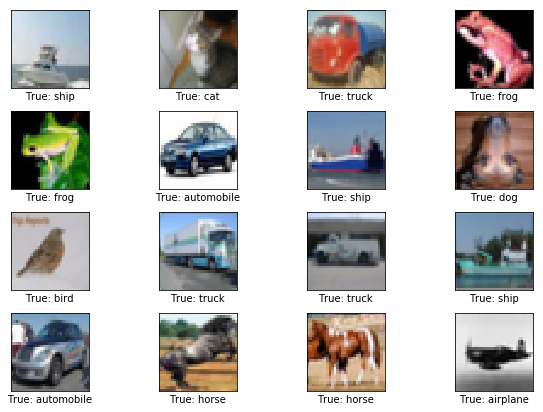

In [10]:
plot_images(images_train[100:116], cls_train[100:116], smooth=False)

# Tensorflow graph

## Placeholder variables

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

## Helper function for creating pre-processing flow

In [12]:
# TODO: try to run it without pre-processing
def pre_process_image(image, training):
    if training:
        # randomly crop and flip the image
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        image = tf.image.random_flip_left_right(image)
        
        # randomly adjust hue, contrast & saturation
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    return images

In [13]:
distorted_images = pre_process(images=x, training=True)

## Helper function function for creating main processing flow

In [14]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    
    phase = pt.Phase.train if training else pt.Phase.infer
    
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='fc1').\
            fully_connected(size=128, name='fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
    
    return y_pred, loss

def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        images = x

        # create tf graph for pre-processing
        images = pre_process(images=images, training=training)

        # create tf graph for the main processing
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss

## Create Neural Network for Training Phase

In [15]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

## Create Neural Network for Test Phase

In [16]:
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Saver

In [17]:
saver = tf.train.Saver()

## Getting the weights

In [18]:
def get_weights_variable(layer_name):
    with tf.variable_scope('network/' + layer_name, reuse=True):
        variable = tf.get_variable('weights')
    return variable

weights_conv1 = get_weights_variable(layer_name='conv1')
weights_conv2 = get_weights_variable(layer_name='conv2')

## Getting the layer outputs

In [19]:
def get_layer_output(layer_name):
    tensor_name = 'network/' + layer_name + '/Relu:0'
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)
    return tensor

output_conv1 = get_layer_output(layer_name='conv1')
output_conv2 = get_layer_output(layer_name='conv2')

# TensorFlow Run
## Create TensorFlow Session

In [20]:
session = tf.Session()

## Restore or initialize variables

In [21]:
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'cifar10.cnn')

try:
    print('Trying to restore last checkpoint...')
    
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    
    print('Restored checkpoint from: ', last_chk_path)
except:
    print('Failed to restore checkpoint, initializing variables instead')
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10.cnn-11025
Restored checkpoint from:  checkpoints/cifar10.cnn-11025


## Helper function to get a random training batch

In [22]:
train_batch_size = 64

def random_batch():
    num_images = len(images_train)
    
    idx = np.random.choice(num_images, size=train_batch_size, replace=False)
    
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    
    return x_batch, y_batch

## Helper function to perform optimization

In [23]:
def optimize(num_iterations):
    start_time = time.time()
    
    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()
        
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        # run the optimizer
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)
        
        # print status every 100 iterations
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # calculate accuracy of the training batch
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            print('Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}'.format(i_global, batch_acc))
        
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session, save_path=save_path, global_step=global_step)
    
    end_time = time.time()
    time_diff = end_time - start_time
    
    print('Time elapsed: ' + str(timedelta(seconds=int(round(time_diff)))))

## Helper function to plot example errors

In [24]:
def plot_example_errors(cls_pred, correct, n_images=16):
    incorrect = (correct == False)
    
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:n_images],
                cls_true=cls_true[0:n_images],
                cls_pred=cls_pred[0:n_images])

## Helper function to plot confusion matrix

In [25]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = '({}) {}'.format(i, class_names[i])
        print(cm[i, :], class_name)
    
    class_numbers = [' ({0})'.format(i) for i in range(num_classes)]
    print(''.join(class_numbers))
    
    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

## Helper function for calculating classifications

In [26]:
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)
    
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0
    
    while i < num_images:
        j = min(i + batch_size, num_images)

        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        i = j
    
    correct = (cls_true == cls_pred)
    
    return correct, cls_pred

# predicted class for the test set
def predict_cls_test():
    return predict_cls(images=images_test, labels=labels_test, cls_true=cls_test)

# classification accuracy
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

## Helper function for showing the performance

In [27]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)
    
    print('Accuracy on test set: {0:.1%} ({1} / {2})'.format(acc, num_correct, num_images))
    
    if show_example_errors:
        print('Example errors:')
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    
    if show_confusion_matrix:
        print('Confusion matrix:')
        plot_confusion_matrix(cls_pred=cls_pred)

## Examples of distorted images

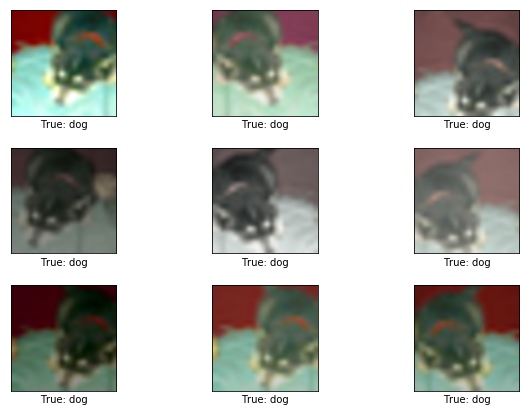

In [28]:
def plot_distorted_image(image, cls_true):
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)
    
    feed_dict = {x: image_duplicates}
    result = session.run(distorted_images, feed_dict)
    
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

img, cls = get_test_image(128)
plot_distorted_image(img, cls)

## Perform optimization

In [ ]:
# it's time consuming on my stunted laptop, hence false
if True:
    optimize(num_iterations=5000)

Global Step:  16100, Training Batch Accuracy:  75.0%
Global Step:  16200, Training Batch Accuracy:  71.9%
Global Step:  16300, Training Batch Accuracy:  67.2%
Global Step:  16400, Training Batch Accuracy:  73.4%
Global Step:  16500, Training Batch Accuracy:  82.8%
Global Step:  16600, Training Batch Accuracy:  71.9%
Global Step:  16700, Training Batch Accuracy:  73.4%
Global Step:  16800, Training Batch Accuracy:  76.6%
Global Step:  16900, Training Batch Accuracy:  84.4%
Global Step:  17000, Training Batch Accuracy:  71.9%
Global Step:  17100, Training Batch Accuracy:  73.4%
Global Step:  17200, Training Batch Accuracy:  75.0%
Global Step:  17300, Training Batch Accuracy:  76.6%
Global Step:  17400, Training Batch Accuracy:  75.0%
Global Step:  17500, Training Batch Accuracy:  68.8%
Global Step:  17600, Training Batch Accuracy:  68.8%
Global Step:  17700, Training Batch Accuracy:  76.6%
Global Step:  17800, Training Batch Accuracy:  76.6%
Global Step:  17900, Training Batch Accuracy: 

## Results

In [ ]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)